# Design of Deep Learning-based Denial-of-Service Attack Detection for an Intrusion Prevention System with Automated Policy Updating

## Model Training

### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import time
import os
from radon.metrics import mi_visit
from radon.complexity import cc_visit


In [2]:
# for checking if cuda is working c:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Dataset (preprocessing)

In [3]:
df = pd.read_csv('Dataset\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
unique_values = df[' Label'].unique()
print(unique_values)

['BENIGN' 'DDoS']


In [6]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [7]:
df.columns = df.columns.str.strip() # pang tanggal ng space kasi may space sa column names hehe

In [8]:
df.columns # yey wala na space sa harap

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [9]:
df['Label'] = df['Label'].apply(lambda x: 1 if 'DDoS' in x else 0)

In [10]:
check_Label = df['Label'].unique()
print(check_Label) # 0 = Benign, 1 = DDoS

[0 1]


In [11]:
df = df.replace([float('inf'), float('-inf')], pd.NA).dropna() # dropping rows with nan and inf values

### Standardize and Splitting

In [12]:
X = df.drop(columns=['Label'])
y = df['Label']

In [13]:
X

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [14]:
y

0         0
1         0
2         0
3         0
4         0
         ..
225740    0
225741    0
225742    0
225743    0
225744    0
Name: Label, Length: 225711, dtype: int64

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # standardize features 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
df['Label'].value_counts() # 0 = Benign, 1 = DDoS

Label
1    128025
0     97686
Name: count, dtype: int64

### Creating dataset and loaders

In [18]:
# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [19]:
# create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [20]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model (LSTM + Vanilla Autoencoder)

In [ ]:
# define the model (Vanilla Autoencoder)
class VanillaAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(VanillaAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim=64):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

In [22]:
# model initialization
input_dim = X_train.shape[1]
latent_dim = 32

autoencoder = VanillaAutoencoder(input_dim, latent_dim).to(device)
lstm = LSTMClassifier(input_size=latent_dim).to(device)

ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
lstm_optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [23]:
train_losses = []
train_accuracies = []
train_f1s = []

test_losses = []
test_accuracies = []
test_f1s = []

In [24]:
# start training time
train_start = time.time()

# hyperparameters
num_epochs = 50
patience = 5
save_path = 'BEST_LSTM_VANILLAAE_MODEL.pth'

# early stopping variables
best_acc = 0
epochs_no_improve = 0

# metric storage
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_f1s, test_f1s = [], []

criterion = nn.BCELoss()

for epoch in range(num_epochs):
    autoencoder.train()
    lstm.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        ae_optimizer.zero_grad()
        lstm_optimizer.zero_grad()

        _, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)
        y_pred = lstm(z_seq)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        ae_optimizer.step()
        lstm_optimizer.step()

        total_loss += loss.item()
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct / total * 100
    train_f1 = f1_score(all_labels, all_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    train_f1s.append(train_f1)

    # eval on test set
    autoencoder.eval()
    lstm.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            _, z = autoencoder(X_batch)
            z_seq = z.unsqueeze(1)
            y_pred = lstm(z_seq)

            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

            predicted = (y_pred > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_acc = correct / total * 100
    test_f1 = f1_score(all_labels, all_preds)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    test_f1s.append(test_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train -> Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.2f}%, F1: {train_f1:.4f}")
    print(f"  Test  -> Loss: {avg_test_loss:.4f}, Accuracy: {test_acc:.2f}%, F1: {test_f1:.4f}")

    # Early stopping and model checkpoint
    if test_acc > best_acc:
        best_acc = test_acc
        epochs_no_improve = 0
        torch.save({
            'autoencoder_state_dict': autoencoder.state_dict(),
            'lstm_state_dict': lstm.state_dict(),
            'ae_optimizer_state_dict': ae_optimizer.state_dict(),
            'lstm_optimizer_state_dict': lstm_optimizer.state_dict(),
            'epoch': epoch,
            'best_acc': best_acc
        }, save_path)
        print(f"Model saved at epoch {epoch+1} with accuracy: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# end training time
train_end = time.time()
training_time = train_end - train_start

# estimate inference time
inference_start = time.time()
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        _, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)
        _ = lstm(z_seq)
inference_end = time.time()
inference_time = inference_end - inference_start

# model file size
model_size_kb = os.path.getsize(save_path) / 1024 if os.path.exists(save_path) else 0.0

# maintainability index
with open('LSTM_VanillaAE_Model.py', 'r') as f:
    code = f.read()
blocks = cc_visit(code)
mi_score = mi_visit(code, blocks)

# final summary outpuit
print("\n=== Summary ===")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Storage Consumption: {model_size_kb:.2f} KB")
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Maintainability Index: {mi_score:.2f}")
print("All tasks completed.")


Epoch [1/50]
  Train -> Loss: 0.0165, Accuracy: 99.69%, F1: 0.9973
  Test  -> Loss: 0.0039, Accuracy: 99.89%, F1: 0.9990
Model saved at epoch 1 with accuracy: 99.89%
Epoch [2/50]
  Train -> Loss: 0.0040, Accuracy: 99.89%, F1: 0.9990
  Test  -> Loss: 0.0028, Accuracy: 99.93%, F1: 0.9994
Model saved at epoch 2 with accuracy: 99.93%
Epoch [3/50]
  Train -> Loss: 0.0032, Accuracy: 99.90%, F1: 0.9991
  Test  -> Loss: 0.0026, Accuracy: 99.92%, F1: 0.9993
No improvement for 1 epoch(s).
Epoch [4/50]
  Train -> Loss: 0.0025, Accuracy: 99.93%, F1: 0.9994
  Test  -> Loss: 0.0024, Accuracy: 99.94%, F1: 0.9995
Model saved at epoch 4 with accuracy: 99.94%
Epoch [5/50]
  Train -> Loss: 0.0023, Accuracy: 99.93%, F1: 0.9994
  Test  -> Loss: 0.0039, Accuracy: 99.89%, F1: 0.9990
No improvement for 1 epoch(s).
Epoch [6/50]
  Train -> Loss: 0.0021, Accuracy: 99.94%, F1: 0.9995
  Test  -> Loss: 0.0016, Accuracy: 99.95%, F1: 0.9996
Model saved at epoch 6 with accuracy: 99.95%
Epoch [7/50]
  Train -> Loss: 0.

### Plots and Results

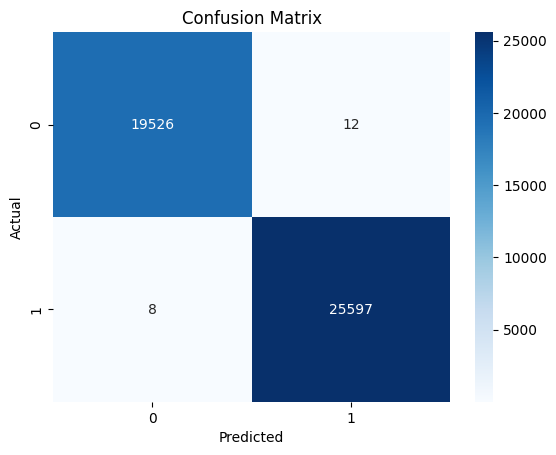

In [25]:
# confusion matrix and roc curve
autoencoder.eval()
lstm.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        _, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)
        y_pred = lstm(z_seq)

        probs = y_pred.cpu().numpy()
        preds = (y_pred > 0.5).float().cpu().numpy()
        labels = y_batch.cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels)

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

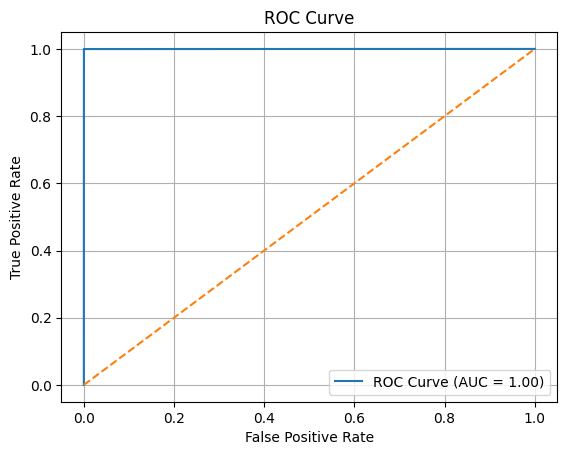

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

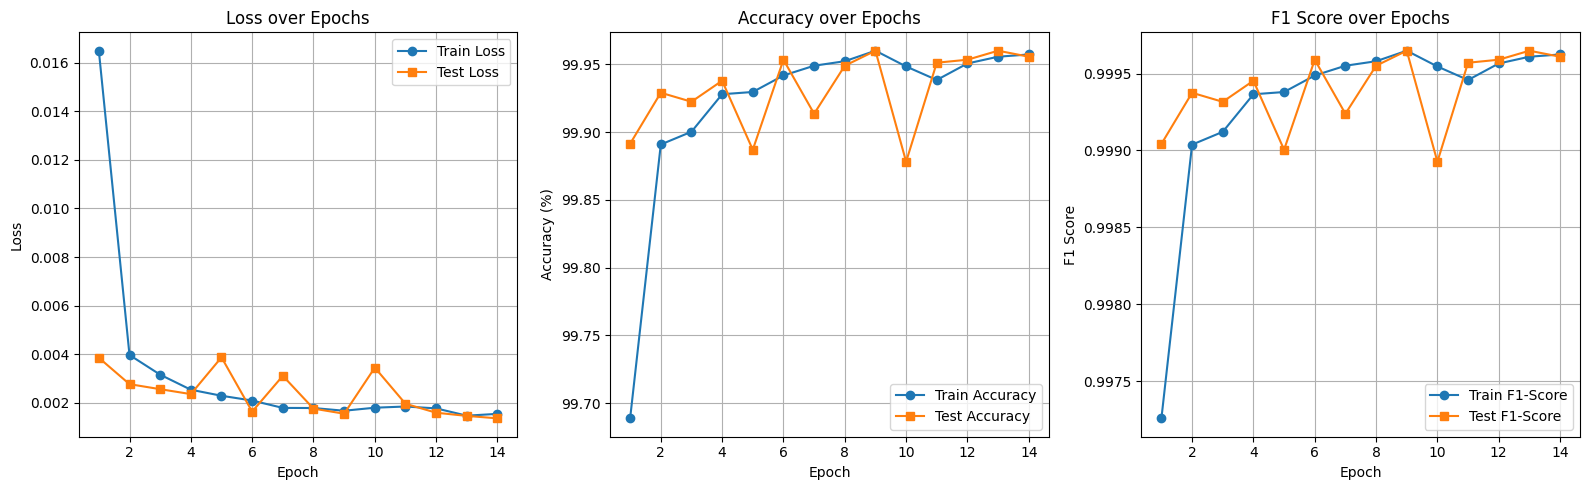

In [28]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# F1-score plot
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1s, label='Train F1-Score', marker='o')
plt.plot(epochs, test_f1s, label='Test F1-Score', marker='s')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
autoencoder.eval()
lstm.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        _, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)
        y_pred = lstm(z_seq)

        predicted = (y_pred > 0.5).float()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
print("\n Classification Report")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'DdoS']))


 Classification Report
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     19538
        DdoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143

